Compiling model...
Building feed-forward neural network...
'build' took 0.061184 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.888253 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [6.34e-01, 4.66e-01, 3.62e+00, 8.26e-01, 3.25e-01, 9.51e-01, 6.93e-01, 2.93e-01]    [6.34e-01, 4.66e-01, 3.62e+00, 8.26e-01, 3.25e-01, 9.51e-01, 6.93e-01, 2.93e-01]    []  
1000      [2.07e-05, 2.62e-05, 8.87e-07, 4.85e-07, 1.83e-06, 2.56e-07, 8.58e-04, 6.40e-04]    [2.07e-05, 2.62e-05, 8.87e-07, 4.85e-07, 1.83e-06, 2.56e-07, 8.58e-04, 6.40e-04]    []  
2000      [5.60e-06, 5.76e-06, 1.87e-07, 8.92e-08, 1.12e-06, 1.49e-06, 6.63e-04, 5.23e-04]    [5.60e-06, 5.76e-06, 1.87e-07, 8.92e-08, 1.12e-06, 1.49e-06, 6.63e-04, 5.23e-04]    []  
3000      [4.33e-06, 3.31e-06, 2.18e-09, 1.31e-08, 9.98e-07, 2.33e-06, 4.68e-04, 3.78e-04]    [4.33e-06, 3.31e-06, 2.18e-09, 1.31e-08, 9.98e-07, 2.33e-06, 4.68e-04, 3.78e-04]    []  
4000      [2.47e-06, 1.80e-06, 1

,x,t,pred_u,pred_v,pred_h,true_u,true_v,true_h
0,-25.000000,0.0,0.000177,0.000067,0.000189,0.000119,0.000016,0.000120
1,-24.803922,0.0,0.000166,0.000168,0.000236,0.000122,0.000042,0.000129
2,-24.607843,0.0,0.000151,0.000275,0.000314,0.000119,0.000069,0.000138
3,-24.411765,0.0,0.000131,0.000383,0.000405,0.000111,0.000097,0.000147
4,-24.215686,0.0,0.000107,0.000485,0.000497,0.000096,0.000125,0.000158
...,...,...,...,...,...,...,...,...
51451,24.215686,1.0,-0.000078,-0.000043,0.000089,-0.000141,-0.000614,0.000630
51452,24.411765,1.0,-0.000012,-0.000043,0.000045,-0.000018,-0.000588,0.000589
51453,24.607843,1.0,0.000044,-0.000048,0.000065,0.000091,-0.000543,0.000550
51454,24.803922,1.0,0.000092,-0.000056,0.000107,0.000182,-0.000481,0.000514


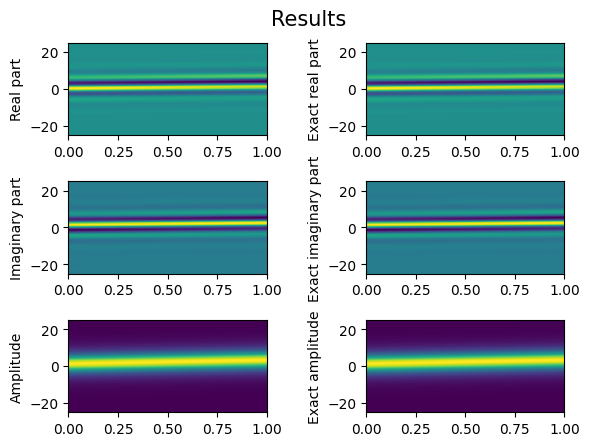

In [4]:
from os import kill
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from IPython.display import display
import tensorflow as tf
import re

x_lower = -25
x_upper = 25
t_lower = 0
t_upper = 1

α = 0
β = 0

α_0 = 0

k = dde.Variable(0.9)
k_true = 1

ω = dde.Variable(0.8)
ω_true = 0.88

x_0 = 0
θ_0 = 0
μ = 4 * (k_true ** 2 - ω_true)

c = dde.Variable(1.9)
c_true = 2 * k_true

x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = -v_t + u_xx + u * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)
    f_v = u_t + v_xx + v * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)

    return [f_u, f_v]


bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)


def init_cond_u(x):
    return np.cos(k_true * x[:, 0:1] + θ_0) * np.sqrt(μ * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x[:, 0:1] - x_0) * np.sqrt(μ))))


def init_cond_v(x):
    return np.sin(k_true * x[:, 0:1] + θ_0) * np.sqrt(μ * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x[:, 0:1] - x_0) * np.sqrt(μ))))


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

# предобработка входа


def input_transform(input_data):
    x = input_data[:, 0:1]
    t = input_data[:, 1:2]

    return x - c * t


# преобразование выхода нейронной сети


def output_transform(input_data, output_data):
    x = input_data[:, 0:1]
    t = input_data[:, 1:2]

    u = output_data[:, 0:1] * tf.cos(k * x - ω * t)
    v = output_data[:, 1:2] * tf.sin(k * x - ω * t)

    return tf.concat([u, v], axis=1)


net = dde.nn.FNN([2] + [32] * 2 + [2], "tanh", "Glorot normal")

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

model = dde.Model(data, net)

model.compile("adam", lr=1e-3, external_trainable_variables=[c, k, ω], loss="MSE")

fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([c, k, ω], period=10, filename=fnamevar)

model.train(iterations=10000, callbacks=[variable])

prediction = model.predict(X_star)
u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q = np.sqrt(u ** 2 + v ** 2)


def u_exact(x, t):
    return np.cos(k_true * x - ω_true * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k_true * t - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x - 2 * k_true * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x - 2 * k_true * t - x_0) * np.sqrt(μ))))


def v_exact(x, t):
    return np.sin(k_true * x - ω_true * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k_true * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k_true * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k_true * t - x_0) * np.sqrt(μ))))


def q_exact(x, t):
    return np.sqrt(μ * np.exp((x - 2 * k_true * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k_true * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k_true * t - x_0) * np.sqrt(μ))))


data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
df.to_orc('my_data_pred1.orc')
display(df)

fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

Text(0.5, 0, 'Epoch')

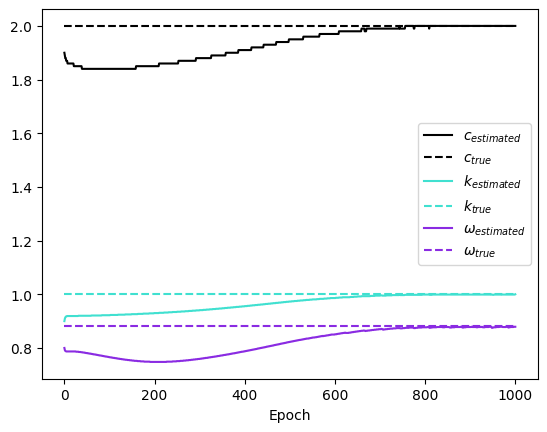

In [7]:
lines = open(fnamevar, "r").readlines()
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

l, columns = Chat.shape

plt.plot(range(l), Chat[:, 0], "k-")
plt.plot(range(l), np.ones(Chat[:, 0].shape) * c_true, "k--")

plt.plot(range(l), Chat[:, 1], c="turquoise", linestyle='-')
plt.plot(range(l), np.ones(Chat[:, 1].shape) * k_true, c="turquoise", linestyle='--')

plt.plot(range(l), Chat[:, 2], c="blueviolet", linestyle='-')
plt.plot(range(l), np.ones(Chat[:, 2].shape) * ω_true, c="blueviolet", linestyle='--')

plt.legend(['$c_{estimated}$', '$c_{true}$', '$k_{estimated}$', '$k_{true}$', '$ω_{estimated}$', '$ω_{true}$'])

plt.xlabel("Epoch")

In [1]:
pip install DeepXDE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 7.0 MB/s eta 0:00:00
